In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import classification_report, accuracy_score, recall_score

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


# 1.1 Handling Categorical Variables

In [2]:
df = pd.read_csv("BankChurners.csv")
df = df.drop(['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2','CLIENTNUM'],axis='columns')
df["Attrition_Flag"] = df["Attrition_Flag"].map({"Existing Customer":0, "Attrited Customer":1})
le = LabelEncoder()
df['Education_Level']= le.fit_transform(df['Education_Level'])
df['Gender']= le.fit_transform(df['Gender'])
df['Card_Category']= le.fit_transform(df['Card_Category'])
df['Income_Category']= le.fit_transform(df['Income_Category'])
df['Marital_Status']= le.fit_transform(df['Marital_Status'])
df.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,0,45,1,3,3,1,2,0,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,0,49,0,5,2,2,4,0,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,0,51,1,3,2,1,3,0,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,0,40,0,4,3,3,4,0,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,0,40,1,3,5,1,2,0,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


# 1.2  Splitting data

In [3]:
X = df.drop(columns=["Attrition_Flag"])
y = df["Attrition_Flag"]
X_train, X_test, y_train, y_test = tts(X, y, stratify=y, test_size=0.2, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 1.3 Getting to know the data

In [4]:
print(df['Attrition_Flag'].value_counts())
df.describe()

Attrition_Flag
0    8500
1    1627
Name: count, dtype: int64


,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,0.160660,46.325960,0.470919,2.346203,3.096574,1.463415,2.863928,0.179816,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,0.367235,8.016814,0.499178,1.298908,1.834812,0.737808,1.504700,0.693039,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,0.000000,41.000000,0.000000,1.000000,2.000000,1.000000,2.000000,0.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,0.000000,46.000000,0.000000,2.000000,3.000000,1.000000,3.000000,0.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,0.000000,52.000000,1.000000,3.000000,5.000000,2.000000,4.000000,0.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,1.000000,73.000000,1.000000,5.000000,6.000000,3.000000,5.000000,3.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


# Helper Functions
- using pipeline instead of directly using X_resampled, y_resampled to ensure SMOTE is applied only inside the CV folds, not on the full dataset.

In [5]:
def evaluate_model(model, model_name, smote=False, X=None, y=None, cv=None):
    if smote:
        pipeline = Pipeline([
            ('smote', SMOTE(random_state=42)),
            ('classifier', model)
        ])
        estimator = pipeline
    else:
        estimator = model

    acc_scores = cross_val_score(estimator, X, y, cv=cv, scoring='accuracy')
    recall_scores = cross_val_score(estimator, X, y, cv=cv, scoring='recall')

    print(f"\n=== {model_name} {'with SMOTE' if smote else ''} ===")
    print("Accuracy:", np.mean(acc_scores))
    print("Recall:", np.mean(recall_scores))

    return np.mean(acc_scores), np.mean(recall_scores)

def metrics_model(model, model_name, smote=False, X=None, y=None):
    if smote:
        smote = SMOTE(random_state=42)
        X,y = smote.fit_resample(X,y)
    model.fit(X,y)
    print(f"\n===== {model_name} =====")
    y_pred = model.predict(X_test)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    cm1 = cm(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

def importances_model(model, model_name, smote=False, X=None, y=None):
    if smote:
        smote = SMOTE(random_state=42)
        X,y = smote.fit_resample(X,y)
    model.fit(X,y)
    print(f"\n===== {model_name} =====")
    importances = model.feature_importances_
    features = X_train.columns
    sns.barplot(x=importances, y=features)
    plt.title("Feature Importances")
    plt.show()


# 2. Handling class imbalance

- The training data set very biased.
- And also continuos variables like Customer_Age, Credit_Limit, Total_Revolving_Bal, Avg_Open_To_Buy, Total_Amt_Chng_Q4_Q1, Total_Trans_Amt,	Total_Trans_Ct can be changed into bins for making it better for random forest algorithm

In [6]:
rf = RandomForestClassifier(random_state=42)
rf_balanced = RandomForestClassifier(class_weight='balanced', random_state=42)

rf_accuracy,rf_recall = evaluate_model(rf,'Random Forest',smote=False,X=X_train,y=y_train,cv=skf)
rf_balanced__accuracy,rf_balanced_recall = evaluate_model(rf_balanced,"Random Forest with class_weight='balanced'",smote=False,X=X_train,y=y_train,cv=skf)
rf_smote_accuracy,rf_smote_recall = evaluate_model(rf,'Random Forest',smote=True,X=X_train,y=y_train,cv=skf)



=== Random Forest  ===
Accuracy: 0.9602516355549463
Recall: 0.813395225464191

=== Random Forest with class_weight='balanced'  ===
Accuracy: 0.9539557962239436
Recall: 0.7726584143825523

=== Random Forest with SMOTE ===
Accuracy: 0.9612383759453469
Recall: 0.8917123489537282


- So it can be concluded that Random Forest with SMOTE is the best to use.


# 3.1 Visualization of existing top features with churn

In [7]:
top_features = [
    'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1',
    'Avg_Utilization_Ratio', 'Credit_Limit'
]

all_pairs = list(combinations(top_features, 2))

import math

def plot_all_2d_scatter_pairs(df, pairs, target='Attrition_Flag', cols=3):
    rows = math.ceil(len(pairs) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = axes.flatten()

    for idx, (f1, f2) in enumerate(pairs):
        sns.scatterplot(
            data=df, x=f1, y=f2, hue=target,
            palette='Set1', alpha=0.6, ax=axes[idx]
        )
        axes[idx].set_title(f'{f1} vs {f2}', fontsize=10)
        axes[idx].legend([], [], frameon=False)

    for j in range(len(pairs), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


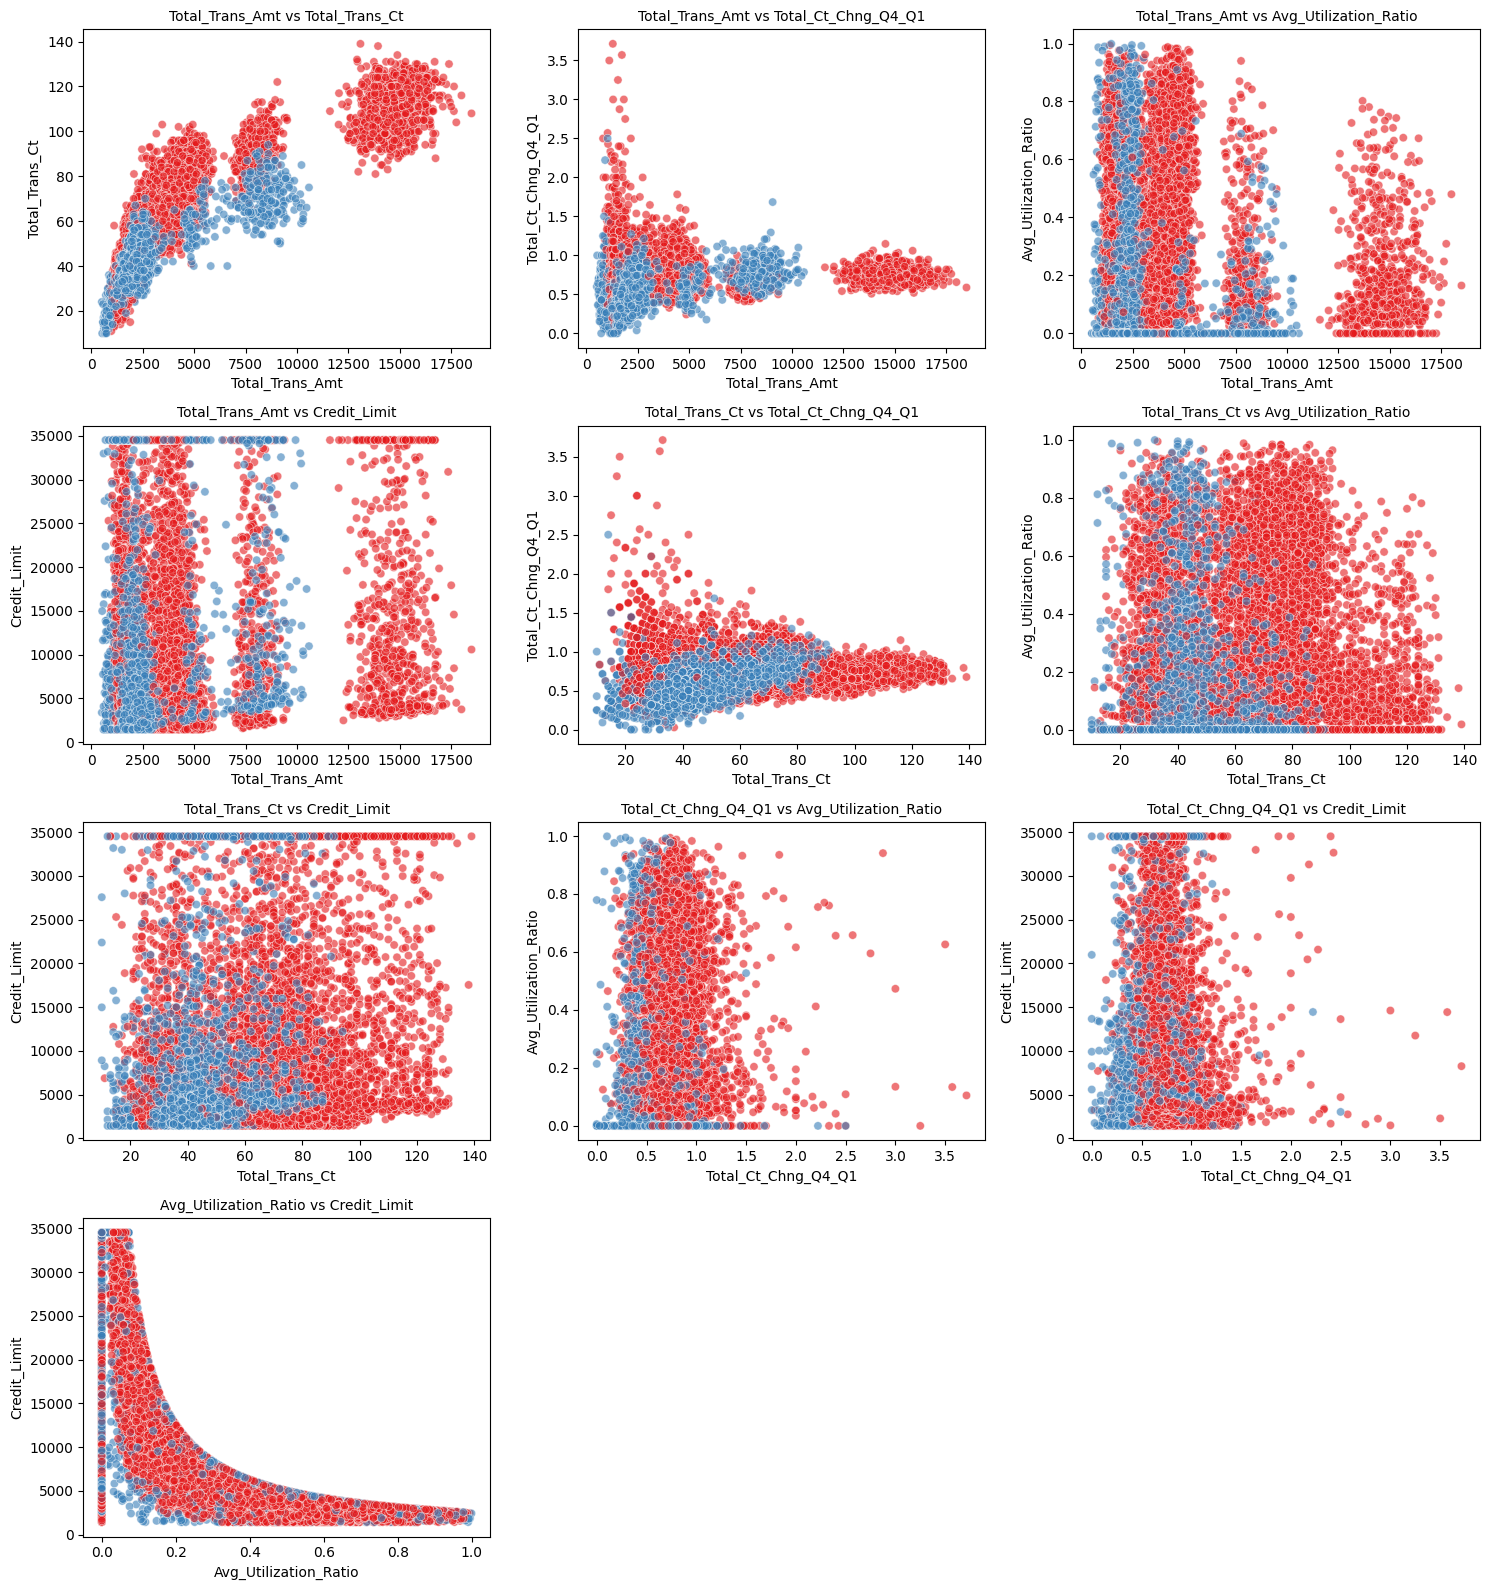


===== RandomForestClassifier with smote =====


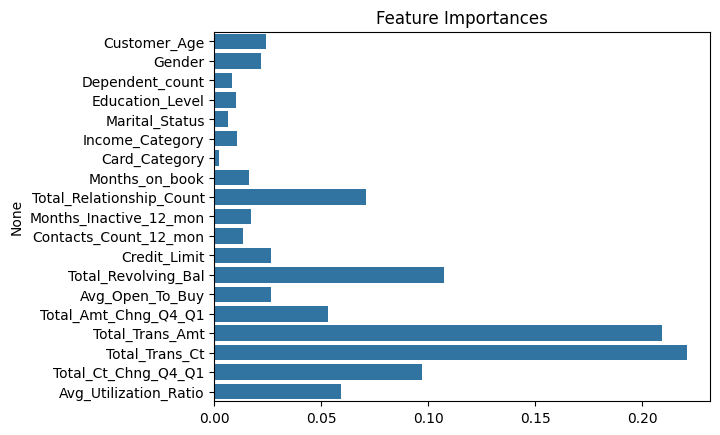

In [8]:
plot_all_2d_scatter_pairs(df, all_pairs)
model = RandomForestClassifier(random_state=42)
importances_model(model,"RandomForestClassifier with smote",smote=True,X=X_train,y=y_train)

# 3.2 Introducing new features 

In [9]:

# 1. Transaction Power
df['Trans_Power'] = df['Total_Trans_Amt'] * df['Total_Trans_Ct']

# 2. Stability Index (lower = more stable)
df['Stability_Index'] = 1 / (1 + df['Total_Ct_Chng_Q4_Q1'])

# 3. Spending Efficiency (spending per unit of credit)
df['Spending_Efficiency'] = df['Total_Trans_Amt'] / (1 + df['Credit_Limit'])

# 4. Utilization Efficiency (how much unused credit is available)
df['Utilization_Gap'] = df['Credit_Limit'] * (1 - df['Avg_Utilization_Ratio'])

# 5. Transaction per Credit Ratio
df['Trans_Ct_per_Credit'] = df['Total_Trans_Ct'] / (1 + df['Credit_Limit'])

# 6. Transaction per Change Ratio
df['Trans_Amt_per_Change'] = df['Total_Trans_Amt'] / (1 + df['Total_Ct_Chng_Q4_Q1'])

# 7. Interaction Feature: Change * Utilization
df['Change_x_Util'] = df['Total_Ct_Chng_Q4_Q1'] * df['Avg_Utilization_Ratio']

# 8. Flag: Underutilized heavy spender
df['Underutilized_Heavy_Spender'] = (
    (df['Avg_Utilization_Ratio'] < 0.2) & 
    (df['Total_Trans_Amt'] > df['Total_Trans_Amt'].median())
).astype(int)

# 9. Flag: Stable Low Use
df['Stable_Low_Use'] = (
    (df['Total_Ct_Chng_Q4_Q1'] < 1) & 
    (df['Avg_Utilization_Ratio'] < 0.2)
).astype(int)


print("New features added to df.")
X = df.drop(columns=["Attrition_Flag"])
y = df["Attrition_Flag"]
X_train, X_test, y_train, y_test = tts(X, y, stratify=y, test_size=0.2, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


New features added to df.



===== RandomForestClassifier with new features =====


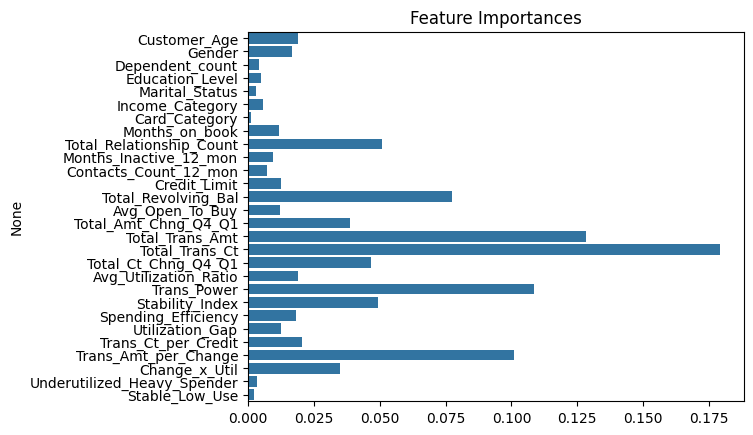

In [10]:
importances_model(model,"RandomForestClassifier with new features",smote=True,X=X_train,y=y_train)


- Removing least important features to reduce cluttering


===== RandomForestClassifier with new features and after removing unnecessary features =====


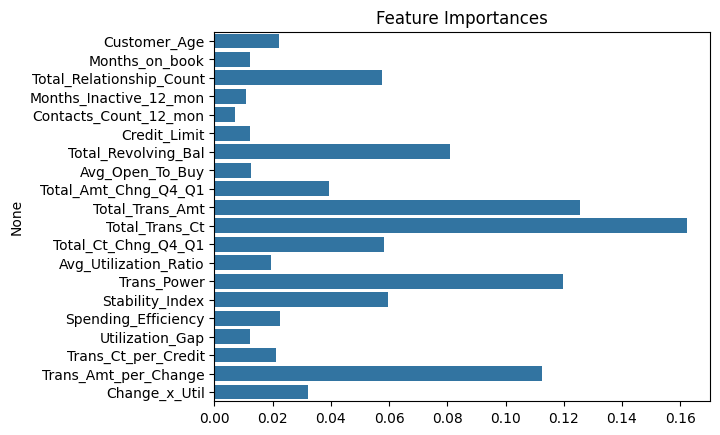

In [11]:
features_to_drop = [
    'Gender',
    'Education_Level',
    'Dependent_count',
    'Marital_Status',
    'Income_Category',
    'Card_Category',
    'Stable_Low_Use',
    'Underutilized_Heavy_Spender',
]

X_train.drop(columns=features_to_drop, inplace=True)
X_test.drop(columns=features_to_drop, inplace=True)
df.drop(columns=features_to_drop, inplace=True)

importances_model(model,"RandomForestClassifier with new features and after removing unnecessary features",smote=True,X=X_train,y=y_train)

In [12]:
rf_accuracy,rf_recall = evaluate_model(model,'Random Forest (After adding new features)',smote=True,X=X_train,y=y_train,cv=skf)



=== Random Forest (After adding new features) with SMOTE ===
Accuracy: 0.9629667710070754
Recall: 0.9101355732390216


# What We Realized
- Feature engineering improved model expressiveness and captured behavioral signals.

- The model now depends on a broader range of features, reducing overfitting risk.

- Some engineered features outperformed the original ones, adding real value.

# 3.3 Manual Binning

- Now based on the importances lets try and check if binning a few continous columns improves the importance or not

In [13]:
columns_to_bin = {
    'Total_Trans_Amt': 5,
    'Total_Trans_Ct': 5,
    'Trans_Power':5,
    'Total_Ct_Chng_Q4_Q1': 4,
    'Avg_Utilization_Ratio': 4,
    'Total_Revolving_Bal': 5,
    'Credit_Limit': 4,
    'Utilization_Gap': 4,
    'Customer_Age': 5
}

df_binned = df.copy()

for col, n_bins in columns_to_bin.items():
    bin_col_name = f"{col}_binned"
    df_binned[bin_col_name] = pd.cut(df_binned[col], bins=n_bins, labels=False)
    df_binned.drop(columns=col, inplace=True)

X_binned = df_binned.drop(columns=["Attrition_Flag"])
y_binned = df_binned["Attrition_Flag"]
X_train_binned, X_test_binned, y_train_binned, y_test_binned = tts(X_binned, y_binned, stratify=y_binned, test_size=0.2, random_state=42)
df_binned.describe()

,Attrition_Flag,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Stability_Index,Spending_Efficiency,Trans_Ct_per_Credit,...,Change_x_Util,Total_Trans_Amt_binned,Total_Trans_Ct_binned,Trans_Power_binned,Total_Ct_Chng_Q4_Q1_binned,Avg_Utilization_Ratio_binned,Total_Revolving_Bal_binned,Credit_Limit_binned,Utilization_Gap_binned,Customer_Age_binned
count,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,...,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,0.160660,35.928409,3.812580,2.341167,2.455317,7469.139637,0.759941,0.594175,1.041533,0.016768,...,0.200651,0.674928,1.634443,0.308482,0.123729,0.751259,1.900365,0.508443,0.498371,1.671176
std,0.367235,7.986416,1.554408,1.010622,1.106225,9090.685324,0.219207,0.076730,0.937505,0.013932,...,0.222150,0.970525,0.940387,0.849318,0.345389,0.993879,1.419875,0.930587,0.918876,0.883776
min,0.000000,13.000000,1.000000,0.000000,0.000000,3.000000,0.000000,0.212134,0.018104,0.000348,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,31.000000,3.000000,2.000000,2.000000,1324.500000,0.631000,0.550055,0.303447,0.005261,...,0.012092,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,36.000000,4.000000,2.000000,2.000000,3474.000000,0.736000,0.587544,0.727013,0.012458,...,0.117300,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,2.000000
75%,0.000000,40.000000,5.000000,3.000000,3.000000,9859.000000,0.859000,0.632111,1.552628,0.025738,...,0.344997,1.000000,2.000000,0.000000,0.000000,2.000000,3.000000,1.000000,1.000000,2.000000
max,1.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,3.397000,1.000000,5.078403,0.066699,...,2.705375,4.000000,4.000000,4.000000,3.000000,3.000000,4.000000,3.000000,3.000000,4.000000


In [14]:
rf_binned_accuracy,rf_binned_recall = evaluate_model(rf,'Random Forest using Manual binning',smote=True,X=X_train_binned,y=y_train_binned,cv=skf)
print("\n=== Random Forest with SMOTE ===")
print("Accuracy:", rf_accuracy)
print("Recall:", rf_recall)


=== Random Forest using Manual binning with SMOTE ===
Accuracy: 0.9500046458138172
Recall: 0.8817152961980549

=== Random Forest with SMOTE ===
Accuracy: 0.9629667710070754
Recall: 0.9101355732390216


- performance slightly dropped.
- Manual binning would reduce granularity and hinder the model’s ability to capture subtle decision boundaries.
- These classifiers—Decision Tree, Random Forest, XGBoost, and CatBoost—automatically determine the most efficient split points for continuous features during training, using techniques like dynamic thresholding or automatic binning. As a result, manual binning is unnecessary, as they are designed to handle raw continuous data effectively.

So we must not do manual binning.

# 4. Model Comparison (with SMOTE)

In [15]:
print("\n=== Random Forest with SMOTE ===")
print("Accuracy:", rf_accuracy)
print("Recall:", rf_recall)

xgb_smote = XGBClassifier(eval_metric='logloss', random_state=42)
lgbm_smote = LGBMClassifier(verbose=-1, random_state=42)
catboost_smote = CatBoostClassifier(verbose=0, random_state=42)

xgb_smote_accuracy,xgb_smote_recall = evaluate_model(xgb_smote,'XGboost',smote=True,X=X_train,y=y_train,cv=skf)
lgbm_smote_accuracy,lgbm_smote_recall = evaluate_model(lgbm_smote,'LightGBM',smote=True,X=X_train,y=y_train,cv=skf)
catboost_smote_accuracy,catboost_smote_recall = evaluate_model(catboost_smote,'Catboost',smote=True,X=X_train,y=y_train,cv=skf)




=== Random Forest with SMOTE ===
Accuracy: 0.9629667710070754
Recall: 0.9101355732390216

=== XGboost with SMOTE ===
Accuracy: 0.9670401596332091
Recall: 0.9170498084291188

=== LightGBM with SMOTE ===
Accuracy: 0.9685214126320438
Recall: 0.9301061007957561

=== Catboost with SMOTE ===
Accuracy: 0.9703732644838958
Recall: 0.9331859711170057


# 5. Hyper parameter tuning


In [16]:
current_params = model.get_params()
print(current_params)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [17]:
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', catboost_smote)
])

param_grid = {
    'classifier__iterations': [200, 500],                     
    'classifier__learning_rate': [0.05, 0.1],                 
    'classifier__depth': [6, 8],                              
    'classifier__l2_leaf_reg': [3, 5],                        
    'classifier__bagging_temperature': [1, 5],                
    'classifier__grow_policy': ['SymmetricTree', 'Lossguide'] 
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,  # Only one param_grid here
    scoring='recall',
    cv=cv,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best Params:", grid_search.best_params_)
print("Best Recall Score:", grid_search.best_score_)


Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] END classifier__bagging_temperature=1, classifier__depth=6, classifier__grow_policy=SymmetricTree, classifier__iterations=200, classifier__l2_leaf_reg=3, classifier__learning_rate=0.1; total time=   6.2s
[CV] END classifier__bagging_temperature=1, classifier__depth=6, classifier__grow_policy=SymmetricTree, classifier__iterations=200, classifier__l2_leaf_reg=3, classifier__learning_rate=0.05; total time=   6.5s
[CV] END classifier__bagging_temperature=1, classifier__depth=6, classifier__grow_policy=SymmetricTree, classifier__iterations=200, classifier__l2_leaf_reg=3, classifier__learning_rate=0.05; total time=   6.8s
[CV] END classifier__bagging_temperature=1, classifier__depth=6, classifier__grow_policy=SymmetricTree, classifier__iterations=200, classifier__l2_leaf_reg=3, classifier__learning_rate=0.05; total time=   7.1s
[CV] END classifier__bagging_temperature=1, classifier__depth=6, classifier__grow_policy=SymmetricT

In [18]:
best_pipeline = grid_search.best_estimator_

# Extract best parameters (they are named like 'classifier__depth', etc.)
best_params_pipeline = grid_search.best_params_

# Strip the 'classifier__' prefix to get pure CatBoost params
catboost_params = {
    key.split("classifier__")[1]: value
    for key, value in best_params_pipeline.items()
    if key.startswith("classifier__")
}

best_catboost_model = CatBoostClassifier(**catboost_params)

In [19]:
catboost_smote_accuracy,catboost_smote_recall = evaluate_model(best_catboost_model,'Catboost and Hyper parameter tuned',smote=True,X=X_train,y=y_train,cv=skf)

0:	learn: 0.6336465	total: 10.3ms	remaining: 2.05s
1:	learn: 0.5821109	total: 19.5ms	remaining: 1.93s
2:	learn: 0.5388190	total: 23.6ms	remaining: 1.55s
3:	learn: 0.5004116	total: 27.5ms	remaining: 1.34s
4:	learn: 0.4603313	total: 32.3ms	remaining: 1.26s
5:	learn: 0.4327529	total: 36.2ms	remaining: 1.17s
6:	learn: 0.4069188	total: 39.4ms	remaining: 1.09s
7:	learn: 0.3818080	total: 42.8ms	remaining: 1.03s
8:	learn: 0.3634278	total: 46.5ms	remaining: 986ms
9:	learn: 0.3440604	total: 49.5ms	remaining: 941ms
10:	learn: 0.3287522	total: 52.5ms	remaining: 903ms
11:	learn: 0.3173476	total: 55.6ms	remaining: 872ms
12:	learn: 0.3023035	total: 58.6ms	remaining: 843ms
13:	learn: 0.2900999	total: 62.5ms	remaining: 831ms
14:	learn: 0.2816861	total: 66.1ms	remaining: 815ms
15:	learn: 0.2722870	total: 69.5ms	remaining: 799ms
16:	learn: 0.2639153	total: 72.7ms	remaining: 782ms
17:	learn: 0.2563338	total: 76.3ms	remaining: 771ms
18:	learn: 0.2511806	total: 80ms	remaining: 762ms
19:	learn: 0.2435734	tot

The improvement in recall (0.3%) after hyperparameter tuning is quite small, and there’s a slight decrease in accuracy (0.6%). While it's good that recall is improved, the trade-off with accuracy might not be ideal. If recall is a critical metric, this might be worth pursuing, but the small gains suggest it might be better to leavve it.

# 5. Results

0:	learn: 0.6279785	total: 5.03ms	remaining: 1s
1:	learn: 0.5692438	total: 8.61ms	remaining: 853ms
2:	learn: 0.5244846	total: 11.9ms	remaining: 784ms
3:	learn: 0.4855395	total: 15.7ms	remaining: 771ms
4:	learn: 0.4464360	total: 19.4ms	remaining: 756ms
5:	learn: 0.4204989	total: 23ms	remaining: 744ms
6:	learn: 0.3953725	total: 26.4ms	remaining: 729ms
7:	learn: 0.3763616	total: 29.9ms	remaining: 718ms
8:	learn: 0.3589839	total: 33.4ms	remaining: 708ms
9:	learn: 0.3411300	total: 37.1ms	remaining: 705ms
10:	learn: 0.3275491	total: 40.4ms	remaining: 695ms
11:	learn: 0.3132496	total: 43.9ms	remaining: 688ms
12:	learn: 0.3002594	total: 47.6ms	remaining: 684ms
13:	learn: 0.2885390	total: 52.4ms	remaining: 696ms
14:	learn: 0.2778482	total: 55.8ms	remaining: 688ms
15:	learn: 0.2700018	total: 60.6ms	remaining: 697ms
16:	learn: 0.2614580	total: 64.7ms	remaining: 696ms
17:	learn: 0.2548057	total: 68.5ms	remaining: 692ms
18:	learn: 0.2465217	total: 71.9ms	remaining: 685ms
19:	learn: 0.2406924	total:

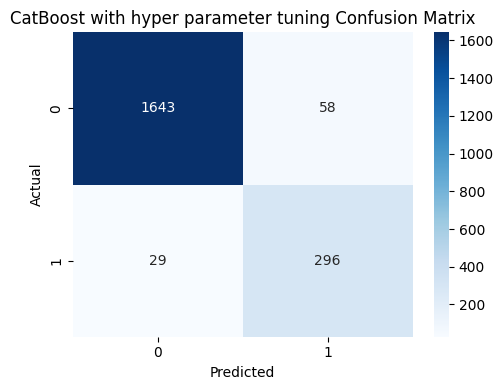


===== CatBoost =====
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1701
           1       0.88      0.90      0.89       325

    accuracy                           0.96      2026
   macro avg       0.93      0.94      0.94      2026
weighted avg       0.97      0.96      0.97      2026

Accuracy: 0.9650
Recall: 0.9046


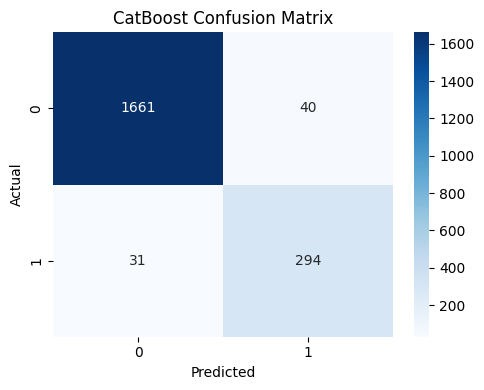


===== LightGBM =====
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98      1701
           1       0.86      0.91      0.88       325

    accuracy                           0.96      2026
   macro avg       0.92      0.94      0.93      2026
weighted avg       0.96      0.96      0.96      2026

Accuracy: 0.9620
Recall: 0.9077


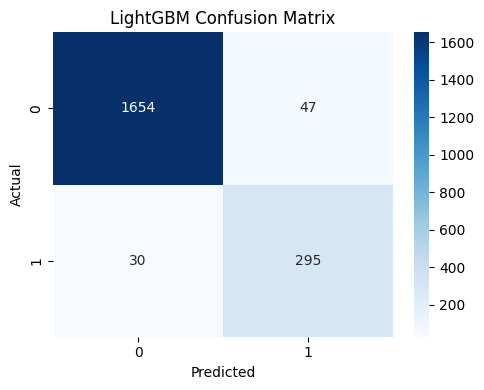

In [20]:
metrics_model(best_catboost_model,'CatBoost with hyper parameter tuning',smote=True,X=X_train,y=y_train)
metrics_model(catboost_smote,'CatBoost',smote=True,X=X_train,y=y_train)
metrics_model(lgbm_smote,'LightGBM',smote=True,X=X_train,y=y_train)

In [21]:
import joblib
joblib.dump(catboost_smote, 'catboost_smote.pkl')
joblib.dump(catboost_smote, 'lightGBM_smote.pkl')


['lightGBM_smote.pkl']

# 6.  Conclusion and Final Thoughts

-  **All models performed very well** with both high accuracy and recall.
-  **CatBoost** for overall best performance balance.
-  Even after hyper parameter tuning there is a very little improvement in recall - 0.3% and a decrease 0.6% accuracy (Crossvalidation recall and cross validation accuracy) so its better to not do that.
-  **LightGBM** gives very similar performance with very similar recall score